Code conneting the three main quantities related to the EBL: the EBL intensity, the proper photon number density and the optical depth. The first one is observationally measured, the second one is important to compute the  electron-positron spectra and the third one sets the absorption of primary gamma-rays.

To-do list:
- [ ] properly include the CMB component (taking into account the redsfhit
- [ ] compute the electron-positron spectra and the secondary gamma-ray emission
- [ ] think about test sample to understand if the uncertanty on EBL are important
    * testing a power-law flux
    * testing a DM flux
- [ ] follow [Blanco arXiv:1804.00005] to develop our integrator

In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import quad, dblquad, tplquad, simps
from scipy.optimize import brentq
from scipy.interpolate import interp1d, interp2d
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import vegas

In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.right'] = True
#
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.minor.size'] = 4
#
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 14

# Constants

In [3]:
a_EM = 1./137.036
m_e = 0.511e6 # [eV]

GeV_to_INVcm = 5.06e13
eV_to_INVcm = GeV_to_INVcm * 1.0e-9
cm_to_kpc = 3.24078e-22
eV_to_INVkpc = eV_to_INVcm / cm_to_kpc
#
#
c_light = 299792458 # [m/s]
J_to_eV = 6.241506363094e18
INVs_to_eV = 6.58e-16
#
#
km_to_Mpc = 3.24078e-20

# Hubble

In [4]:
def Hubble(z):
    # output in [1/s]
    
    H0 = 70.0 # km/s/Mpc
    H0 = H0*km_to_Mpc
    O_m = 0.3
    O_L = 0.7
    
    return H0 * np.sqrt(O_m*(1.+z)**3 + O_L)

# Cross-sections

Gamma-gamma cross-section

In [5]:
def s_energy(E_g, eps, cos):
    return E_g*eps/2/m_e**2*(1.-cos)

def sigma_gg(s_energy):
    
    # output in [1/eV^2]
    
    if s_energy >= 1.:
        #
        beta = np.sqrt(1. - 1./s_energy)
        #
        t_1 = (3. - beta**4) * np.log((1.+beta)/(1.-beta))
        t_2 = 2. * beta * (2. - beta**2)
        #
        f_1 = np.pi/2.*(a_EM**2/m_e**2)
        f_2 = (1. - beta**2)
    
        return f_1*f_2*(t_1 - t_2)
    else:
        return 0.0
    
sigma_gg = np.vectorize(sigma_gg)

# Dominguez et al. arXiv:1007.1459

EBL data from Dominguez et al. arXiv:1007.1459. They provide the EBL intensity for different redshift and the final optical depth. Below, I recover their optical depth starting from the EBL intensity.

## EBL intensity

In [6]:
filename = 'Libraries/tau_dominguez11.txt'

dominguez_tau = np.loadtxt(filename)

#f = open(filename)
#for i in range(0,5):
#    print(f.readline())

In [7]:
dominguez_tau_z = [ 0.01, 0.02526316, 0.04052632, 0.05578947, 0.07105263, 
                   0.08631579, 0.10157895, 0.11684211, 0.13210526, 0.14736842, 
                   0.16263158, 0.17789474, 0.19315789, 0.20842105, 0.22368421, 
                   0.23894737, 0.25421053, 0.26947368, 0.28473684, 0.3, 0.35, 
                   0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9,
                   0.95, 1., 1.2, 1.4, 1.6, 1.8, 2.]

In [8]:
filename = 'Libraries/ebl_dominguez11.txt'

dominguez_ebl = np.loadtxt(filename)

#f = open(filename)
#for i in range(0,10):
#    print(f.readline())

In [9]:
dominguez_ebl_z = [0,0.01,0.03,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0,1.25,1.5,2.0,2.5,3.0,3.9]
dominguez_ebl_x_label = r'$\lambda \,[{\rm \mu m}]$'
dominguez_ebl_y_label = r'$\lambda I_\lambda \,[{\rm nW \, m^{-2} \, sr^{-1}}]$'

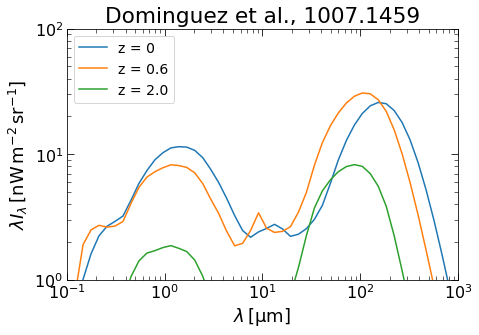

In [10]:
plt.figure(figsize=(7,5))

plt.loglog(dominguez_ebl[:,0],dominguez_ebl[:,1], label='z = {}'.format(dominguez_ebl_z[0]))
plt.loglog(dominguez_ebl[:,0],dominguez_ebl[:,10], label='z = {}'.format(dominguez_ebl_z[9]))
plt.loglog(dominguez_ebl[:,0],dominguez_ebl[:,15], label='z = {}'.format(dominguez_ebl_z[14]))

plt.legend()

plt.xlabel(dominguez_ebl_x_label)
plt.ylabel(dominguez_ebl_y_label)
plt.title('Dominguez et al., 1007.1459')

plt.xlim(1.0e-1,1.0e3)
plt.ylim(1,100)

plt.tight_layout()
plt.savefig("Figures/Dominguez_intensity.pdf", bbox_inches="tight")

plt.show()

In [11]:
dominguez_ebl_density = np.copy(dominguez_ebl)

len_z = len(dominguez_ebl_z)

# dominguez_ebl_density[:,0] = [micron]
dominguez_ebl_density[:,0] = c_light/dominguez_ebl_density[:,0]/1.0e-6 # [s^-1]
dominguez_ebl_density[:,0] = dominguez_ebl_density[:,0]*2.*np.pi*INVs_to_eV # [eV]

for i in range(1,len_z+1):
    
    # dominguez_ebl_density[:,i] = [nJ/s/sr/m^2]
    
    dominguez_ebl_density[:,i] = dominguez_ebl_density[:,i]*1.0e-9*4.*np.pi/c_light # [J/m^3]
    dominguez_ebl_density[:,i] = dominguez_ebl_density[:,i]*J_to_eV # [eV/m^3]
    dominguez_ebl_density[:,i] = dominguez_ebl_density[:,i]/dominguez_ebl_density[:,0]/1.0e6 # [cm^-3]
    
    # redshift evolution
    
    dominguez_ebl_density[:,i] = dominguez_ebl_density[:,i] * (1.+dominguez_ebl_z[i-1])**3

dominguez_ebl_density_x_label = r'$\epsilon \,[{\rm eV}]$'
dominguez_ebl_density_y_label = r'$\epsilon \, {\rm d}n / {\rm d}\epsilon \,[{\rm cm^{-3}}]$'

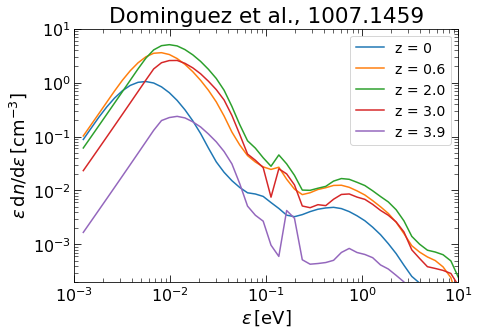

In [12]:
plt.figure(figsize=(7,5))

plt.loglog(dominguez_ebl_density[:,0],dominguez_ebl_density[:,1], label='z = {}'.format(dominguez_ebl_z[0]))
plt.loglog(dominguez_ebl_density[:,0],dominguez_ebl_density[:,10], label='z = {}'.format(dominguez_ebl_z[9]))
plt.loglog(dominguez_ebl_density[:,0],dominguez_ebl_density[:,15], label='z = {}'.format(dominguez_ebl_z[14]))
plt.loglog(dominguez_ebl_density[:,0],dominguez_ebl_density[:,17], label='z = {}'.format(dominguez_ebl_z[16]))
plt.loglog(dominguez_ebl_density[:,0],dominguez_ebl_density[:,18], label='z = {}'.format(dominguez_ebl_z[17]))

plt.legend()

plt.xlabel(dominguez_ebl_density_x_label)
plt.ylabel(dominguez_ebl_density_y_label)
plt.title('Dominguez et al., 1007.1459')

plt.xlim(1.0e-3,1.0e1)
plt.ylim(2.0e-4,1.0e1)

plt.tight_layout()
plt.savefig("Figures/Dominguez_proper_number_density.pdf", bbox_inches="tight")

plt.show()

## Functions

In [13]:
dominguez_ebl_en = np.copy(dominguez_ebl)
# dominguez_ebl[:,0] = [micron]  -  to  -  [eV]
dominguez_ebl_en[:,0] = c_light/dominguez_ebl_en[:,0]/1.0e-6 # [s^-1]
dominguez_ebl_en[:,0] = dominguez_ebl_en[:,0]*2.*np.pi*INVs_to_eV # [eV]

f_dominguez_ebl = interp2d(dominguez_ebl_z, 
                           dominguez_ebl_en[:,0], 
                           dominguez_ebl_en[:,1:19], 
                           fill_value=0.0)

def dnde_dominguez(z, eps, ebl=f_dominguez_ebl):
    
    # ebl = f_dominguez_ebl(z) [nJ/s/sr/m^2]
    # z = redsfhit; eps = energy in [eV]
    
    out = ebl(z,eps)*1.0e-9*4.*np.pi/c_light # [J/m^3]
    out = out*J_to_eV # [eV/m^3]
    out = out/eps/1.0e6 # [cm^-3]
    out = out * (1.+z)**3 # [cm^-3]
    out = out/eps # [cm^-3 eV^-1]
    
    return out

dnde_dominguez = np.vectorize(dnde_dominguez)

## Optical depth

Here, I compute the optical depth through "simps" and "vegas" integration. The latter is faster and has a good accuracy even with 1.0e4 iteration. There is clearly a small bias in our results wrt the values reported in [Dominguez et al], though it seems not signficant.

In the plots shown at the end you can seen the good agreemnt of our result for the optical depth $\tau$ and the absorption $e^{-\tau}$ which is more sensitive to small variations of $\tau$.

In [14]:
def tau_dominguez_simps(E_g, z, dnde=dnde_dominguez, 
                        precision_en=200, 
                        precision_z=100, 
                        precision_cos=20, 
                        eps_min=dominguez_ebl_en[-1,0], 
                        eps_max=dominguez_ebl_en[0,0]):
    
    eps_threshold_min = 2*m_e**2/E_g/2./(1.+z) # (1-cos)=2; cos=-1 INTEGRAL OVER z
    
    z_arr = np.linspace(0.0, z, precision_z)
    eps_arr = np.logspace(np.log10(eps_threshold_min), np.log10(eps_max), precision_en)
    cos_arr = np.linspace(-1., 1.-1.0e-14, precision_cos)
    
    z_ms, cos_ms, eps_ms = np.meshgrid(z_arr, cos_arr, eps_arr, indexing='ij')
    
    s_ms = s_energy(E_g, eps_ms, cos_ms)*(1.+z_ms) # INTEGRAL OVER z
    eps_th_ms = 2.*m_e**2/E_g/(1.-cos_ms)/(1.+z_ms) #INTEGRAL OVER z
    
    t_1 = c_light/Hubble(z_ms)/(1.+z_ms)
    t_2 = (1.-cos_ms)/2.
    t_3 = sigma_gg(s_ms)*np.heaviside(eps_ms - eps_th_ms, 1.0)*dnde(z_ms, eps_ms)
    
    integrand = t_1 * t_2 * t_3
    integral_1 = simps(integrand, eps_arr)
    integral_2 = simps(integral_1, cos_arr)
    integral_3 = simps(integral_2, z_arr)

    return integral_3*1.0e2/eV_to_INVcm**2

tau_dominguez_simps = np.vectorize(tau_dominguez_simps)

In [15]:
def tau_dominguez_vegas(E_g, z, dnde=dnde_dominguez, 
                        neval=1.0e4, 
                        eps_min=dominguez_ebl_en[-1,0], 
                        eps_max=dominguez_ebl_en[0,0]):
    
    #@vegas.batchintegrand
    def f_batch(x):
        # x = [eps, cos, z]
            if x[0] >= 2*m_e**2/E_g/(1.-x[1])/(1.+x[2]):
                s = s_energy(E_g, x[0], x[1])*(1.+x[2])
                out = 1./Hubble(x[2])/(1.+x[2]) * (1.-x[1])/2. * sigma_gg(s) * dnde(x[2], x[0])
                return out
            else:
                return 0.0
        
    integ = vegas.Integrator([[eps_min, eps_max], [-1.,1.], [0., z]])
    integ(f_batch, nitn=7, neval=1000)
    result = integ(f_batch, nitn=10, neval=neval)
        
    if result.shape == (1,):
        val = result[0].mean*c_light*1.0e2/eV_to_INVcm**2
    else:
        val = result.mean*c_light*1.0e2/eV_to_INVcm**2
        
    return val

In [16]:
# SCAN to make the comparison with Dominguez et al.
#
#our_tau = []
#
#for z in tqdm(dominguez_tau_z):
#    our_tau_z = []
#    for en in dominguez_tau[:,0]:
#        E_g = en*1.0e12
#        our_tau_z.append(tau_dominguez_vegas(E_g, z))
#    our_tau.append(np.array(our_tau_z))
#
#val = np.zeros(dominguez_tau.shape)
#val[:,0] = dominguez_tau[:,0]
#val[:,1:40] = our_tau.transpose()
#
#np.savetxt('Libraries/our_tau_dominguez.dat', val)

In [17]:
#np.savetxt('Libraries/our_tau_dominguez_backup.dat', np.array(our_tau))

In [18]:
#val = np.zeros(dominguez_tau.shape)
#val[:,0] = dominguez_tau[:,0]
#val[:,1:40] = our_tau.transpose()
#
#np.savetxt('Libraries/our_tau_dominguez.dat', val)

In [19]:
our_tau = np.loadtxt('Libraries/our_tau_dominguez.dat')

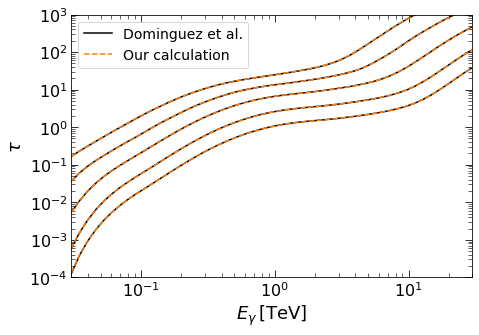

In [20]:
plt.figure(figsize=(7,5))

for i in [7,15,24,33,39]:
    plt.loglog(dominguez_tau[:,0], dominguez_tau[:,i], c='black', ls='-')
    plt.loglog(our_tau[:,0], our_tau[:,i], c='C1', ls='--')
    
plt.plot([-1,-1],[-1,-1], c='black', ls='-', label='Dominguez et al.')
plt.plot([-1,-1],[-1,-1], c='C1', ls='--', label='Our calculation')
plt.legend()
    
plt.xlim(dominguez_tau[0,0], dominguez_tau[-1,0])
plt.ylim(1.0e-4, 1.0e3)

plt.xlabel(r'$E_\gamma \,[{\rm TeV}]$')
plt.ylabel(r'$\tau$')
    
plt.tight_layout()
plt.savefig("Figures/Dominguez_tau.pdf", bbox_inches="tight")
    
plt.show()

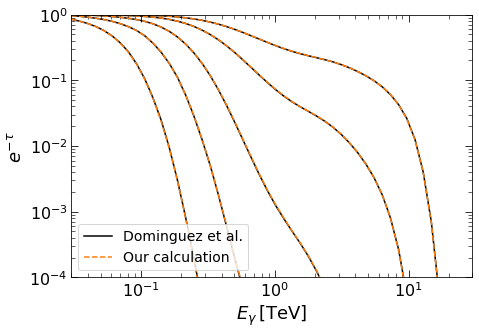

In [21]:
plt.figure(figsize=(7,5))

for i in [7,15,24,33,39]:
    plt.loglog(dominguez_tau[:,0], np.exp(-dominguez_tau[:,i]), c='black', ls='-')
    plt.loglog(our_tau[:,0], np.exp(-our_tau[:,i]), c='C1', ls='--')
    
plt.plot([-1,-1],[-1,-1], c='black', ls='-', label='Dominguez et al.')
plt.plot([-1,-1],[-1,-1], c='C1', ls='--', label='Our calculation')
plt.legend()
    
plt.xlim(dominguez_tau[0,0], dominguez_tau[-1,0])
plt.ylim(1.0e-4,1.0e0)
    
plt.xlabel(r'$E_\gamma \,[{\rm TeV}]$')
plt.ylabel(r'$e^{-\tau}$')
    
plt.tight_layout()
plt.savefig("Figures/Dominguez_exp_tau.pdf", bbox_inches="tight")
    
plt.show()

# Franceschini et al. arXiv:0805.1841

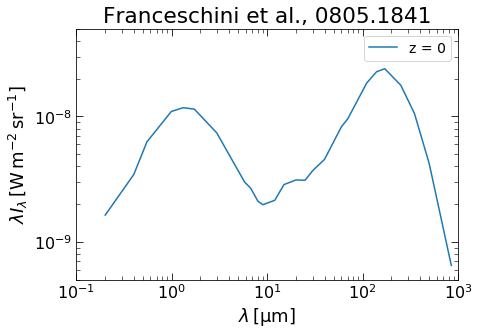

In [22]:
fra_ebl = [[-0.6948, -8.787], [-0.3953, -8.463], [-0.2587, -8.204], [-0.002907, -7.961], 
           [0.1221, -7.931], [0.2384, -7.942], [0.4738, -8.132], [0.7645, -8.523], 
           [0.8285, -8.572], [0.9041, -8.676], [0.9564, -8.704], [1.081, -8.669], 
           [1.177, -8.544], [1.302, -8.507], [1.398, -8.509], [1.480, -8.431], 
           [1.602, -8.343], [1.779, -8.083], [1.846, -8.019], [2.044, -7.734], 
           [2.148, -7.644], [2.233, -7.620], [2.401, -7.752], [2.544, -7.977], 
           [2.698, -8.375], [2.930, -9.188]]

fra_ebl = 10**np.array(fra_ebl)

fra_ebl_x_label = r'$\lambda \,[{\rm \mu m}]$'
fra_ebl_y_label = r'$\lambda I_\lambda \,[{\rm W \, m^{-2} \, sr^{-1}}]$'


plt.figure(figsize=(7,5))

plt.loglog(fra_ebl[:,0],fra_ebl[:,1], label='z = {}'.format(dominguez_ebl_z[0]))

plt.legend()

plt.xlabel(fra_ebl_x_label)
plt.ylabel(fra_ebl_y_label)
plt.title('Franceschini et al., 0805.1841')

plt.xlim(1.0e-1,1.0e3)
plt.ylim(5.0e-10,5.0e-8)

plt.tight_layout()
plt.savefig("Figures/Franceschini_intensity.pdf", bbox_inches="tight")

plt.show()

In [23]:
fra_ebl_density = np.copy(fra_ebl)


# fra_ebl_density[:,0] = [micron]
fra_ebl_density[:,0] = c_light/fra_ebl_density[:,0]/1.0e-6 # [s^-1]
fra_ebl_density[:,0] = fra_ebl_density[:,0]*2.*np.pi*INVs_to_eV # [eV]

# fra_ebl_density[:,1] = [J/s/sr/m^2]
    
fra_ebl_density[:,1] = fra_ebl_density[:,1]*4.*np.pi/c_light # [J/m^3]
fra_ebl_density[:,1] = fra_ebl_density[:,1]*J_to_eV # [eV/m^3]
fra_ebl_density[:,1] = fra_ebl_density[:,1]/fra_ebl_density[:,0]/1.0e6 # [cm^-3]
    
# redshift evolution
#fra_ebl_density[:,i] = fra_ebl_density[:,i] * (1.+fra_ebl_z[i-1])**3

fra_ebl_density_x_label = r'$\epsilon \,[{\rm eV}]$'
fra_ebl_density_y_label = r'$\epsilon \, {\rm d}n / {\rm d}\epsilon \,[{\rm cm^{-3}}]$'

In [24]:
fra_ebl_density_test = [[-2.833, -0.9333],[-2.601, -0.3487],[-2.450, -0.1128],[-2.306, -0.03077],
                        [-2.138, -0.06667],[-2.052, -0.1744],[-1.757, -0.8410],[-1.680, -0.9949],
                        [-1.514, -1.400],[-1.379, -1.646],[-1.305, -1.790],[-1.208, -1.882],
                        [-1.079, -2.056],[-0.9876, -2.272],[-0.8607, -2.431],[-0.8083, -2.456],
                        [-0.7310, -2.426],[-0.6703, -2.441],[-0.5572, -2.410],[-0.4745, -2.364],
                        [-0.3779, -2.338],[-0.1462, -2.385],[-0.03310, -2.482],[0.09931, -2.646],
                        [0.3531, -3.144],[0.4883, -3.538],[0.5655, -3.703]]

fra_ebl_density_test = 10**np.array(fra_ebl_density_test)

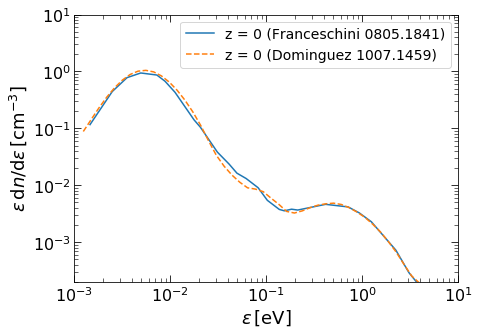

In [25]:
plt.figure(figsize=(7,5))

plt.loglog(fra_ebl_density[:,0],fra_ebl_density[:,1], 
           label='z = 0 (Franceschini 0805.1841)')
plt.loglog(dominguez_ebl_density[:,0],dominguez_ebl_density[:,1], ls='--',
           label='z = 0 (Dominguez 1007.1459)')

plt.legend()

plt.xlabel(fra_ebl_density_x_label)
plt.ylabel(fra_ebl_density_y_label)

plt.xlim(1.0e-3,1.0e1)
plt.ylim(2.0e-4,1.0e1)

plt.tight_layout()
plt.savefig("Figures/Comparison_proper_number_density.pdf", bbox_inches="tight")

plt.show()

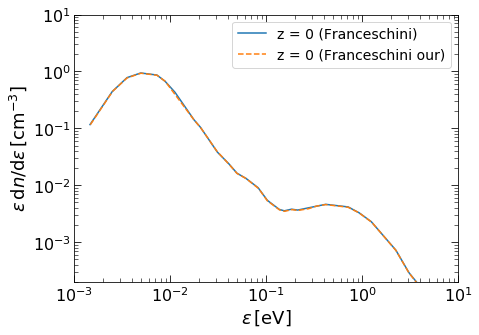

In [26]:
plt.figure(figsize=(7,5))

plt.loglog(fra_ebl_density[:,0],fra_ebl_density[:,1], 
           label='z = 0 (Franceschini)')
plt.loglog(fra_ebl_density_test[:,0],fra_ebl_density_test[:,1], ls='--',
           label='z = 0 (Franceschini our)')

plt.legend()

plt.xlabel(fra_ebl_density_x_label)
plt.ylabel(fra_ebl_density_y_label)

plt.xlim(1.0e-3,1.0e1)
plt.ylim(2.0e-4,1.0e1)

plt.tight_layout()
plt.savefig("Figures/Franceschini_proper_number_density.pdf", bbox_inches="tight")

plt.show()